# Can we do forecasting prices for neighbourhoods, accomodation types and a date?
## Business Understanding
For some accomodations prices might be varying over the year. Given a neighborhood, accomodation type and a date, what is the forecasted average price for it? Can we give a good forecast for this?

In [5]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline



## Data Understanding - Gather
Three datasets are provided. 
* Listings, including full descriptions and average review score
* Reviews, including unique id for each reviewer and detailed comments
* Calendar, including listing id and the price and availability for that day
In addition to the data we already used for neighbourhoods, accomodation types and prices we will here need also some calendar data. Specifically to retrieve date dependent prices and also to filter for accommodation availabilities for dates.

From evalations in [evaluate_types_per_neighbourhood.ipynb](evaluate_types_per_neighbourhood.ipynb)  we already know, we have to use neighbourhood_group_cleansed as data source for the neighbourhoods.
From [evaluate_price_per_type_and_neighbourhood.ipynb](evaluate_price_per_type_and_neighbourhood.ipynb) we know how to retrieve and transform the base prices per day. What we still need in addition here is the calendar information about prices for a date and also about availabilites.

In [6]:
# Read the datasets
df_seattle_calendar = pd.read_csv('./data/seattle/calendar.csv')
df_seattle_listings = pd.read_csv('./data/seattle/listings.csv')
# df_seattle_reviews = pd.read_csv('./data/seattle/reviews.csv')


In [7]:
# Prepare data like we did in evaluate_types_per_neighbourhood.ipynb
neighbourhood_group_cleansed = set(df_seattle_listings['neighbourhood_group_cleansed'])
acco_types = set(df_seattle_listings['property_type'].dropna(axis=0))

## Data Understanding - Assess
What information columns are probably the best to retrieve the desired data?
We already know about what columns to use for the neighbourhood and property type related data and also the base price information. How do we get the additional date related data?

In [8]:
df_seattle_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [9]:
#  reduce data to needed columns
forecast_df = df_seattle_listings[['id', 'neighbourhood_group_cleansed', 'property_type', 'price']]
forecast_df


,id,neighbourhood_group_cleansed,property_type,price
0,241032,Queen Anne,Apartment,$85.00
1,953595,Queen Anne,Apartment,$150.00
2,3308979,Queen Anne,House,$975.00
3,7421966,Queen Anne,Apartment,$100.00
4,278830,Queen Anne,House,$450.00
...,...,...,...,...
3813,8101950,Other neighborhoods,House,$359.00
3814,8902327,Capitol Hill,Apartment,$79.00
3815,10267360,Rainier Valley,House,$93.00
3816,9604740,Capitol Hill,Condominium,$99.00


In [10]:
#  we need to enrich our listing data by calendar data
merged_forecast_df = pd.merge(df_seattle_calendar, forecast_df, left_on='listing_id', right_on='id', how='left').drop('id', axis=1)
merged_forecast_df

,listing_id,date,available,price_x,neighbourhood_group_cleansed,property_type,price_y
0,241032,2016-01-04,t,$85.00,Queen Anne,Apartment,$85.00
1,241032,2016-01-05,t,$85.00,Queen Anne,Apartment,$85.00
2,241032,2016-01-06,f,NaN,Queen Anne,Apartment,$85.00
3,241032,2016-01-07,f,NaN,Queen Anne,Apartment,$85.00
4,241032,2016-01-08,f,NaN,Queen Anne,Apartment,$85.00
...,...,...,...,...,...,...,...
1393565,10208623,2016-12-29,f,NaN,Queen Anne,Apartment,$87.00
1393566,10208623,2016-12-30,f,NaN,Queen Anne,Apartment,$87.00
1393567,10208623,2016-12-31,f,NaN,Queen Anne,Apartment,$87.00
1393568,10208623,2017-01-01,f,NaN,Queen Anne,Apartment,$87.00


## Data Preparation - Clean
We do not want to base our model on data irrelevant for the given date. We also want to have forecasts only for specic months - not for exact days.

In [11]:
# drop all the rows where the accomodation is not available within that time

merged_forecast_df.drop(merged_forecast_df.index[merged_forecast_df['available'] == 'f'], inplace = True)
merged_forecast_df


,listing_id,date,available,price_x,neighbourhood_group_cleansed,property_type,price_y
0,241032,2016-01-04,t,$85.00,Queen Anne,Apartment,$85.00
1,241032,2016-01-05,t,$85.00,Queen Anne,Apartment,$85.00
9,241032,2016-01-13,t,$85.00,Queen Anne,Apartment,$85.00
10,241032,2016-01-14,t,$85.00,Queen Anne,Apartment,$85.00
14,241032,2016-01-18,t,$85.00,Queen Anne,Apartment,$85.00
...,...,...,...,...,...,...,...
1393207,10208623,2016-01-06,t,$87.00,Queen Anne,Apartment,$87.00
1393208,10208623,2016-01-07,t,$87.00,Queen Anne,Apartment,$87.00
1393211,10208623,2016-01-10,t,$87.00,Queen Anne,Apartment,$87.00
1393212,10208623,2016-01-11,t,$87.00,Queen Anne,Apartment,$87.00


In [12]:
# we do not need the exact day, month is enought
extract_month = lambda col: col.split('-')[1]
merged_forecast_df['date'] = merged_forecast_df['date'].apply(extract_month)
set(merged_forecast_df['date'])


{'01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'}

In [13]:
# the price for our estimation will be the one from the calendar (price_x). 
# If it is not available - use the standard price (price_y)

merged_forecast_df['price_x'].fillna(merged_forecast_df['price_y'], inplace=True)

merged_forecast_df

,listing_id,date,available,price_x,neighbourhood_group_cleansed,property_type,price_y
0,241032,01,t,$85.00,Queen Anne,Apartment,$85.00
1,241032,01,t,$85.00,Queen Anne,Apartment,$85.00
9,241032,01,t,$85.00,Queen Anne,Apartment,$85.00
10,241032,01,t,$85.00,Queen Anne,Apartment,$85.00
14,241032,01,t,$85.00,Queen Anne,Apartment,$85.00
...,...,...,...,...,...,...,...
1393207,10208623,01,t,$87.00,Queen Anne,Apartment,$87.00
1393208,10208623,01,t,$87.00,Queen Anne,Apartment,$87.00
1393211,10208623,01,t,$87.00,Queen Anne,Apartment,$87.00
1393212,10208623,01,t,$87.00,Queen Anne,Apartment,$87.00


In [14]:
# convert price to number
convert_to_float = lambda col: float(col.split('$')[1].replace(',',''))
merged_forecast_df['price'] = merged_forecast_df['price_x'].apply(convert_to_float)
merged_forecast_df

,listing_id,date,available,price_x,neighbourhood_group_cleansed,property_type,price_y,price
0,241032,01,t,$85.00,Queen Anne,Apartment,$85.00,85.0
1,241032,01,t,$85.00,Queen Anne,Apartment,$85.00,85.0
9,241032,01,t,$85.00,Queen Anne,Apartment,$85.00,85.0
10,241032,01,t,$85.00,Queen Anne,Apartment,$85.00,85.0
14,241032,01,t,$85.00,Queen Anne,Apartment,$85.00,85.0
...,...,...,...,...,...,...,...,...
1393207,10208623,01,t,$87.00,Queen Anne,Apartment,$87.00,87.0
1393208,10208623,01,t,$87.00,Queen Anne,Apartment,$87.00,87.0
1393211,10208623,01,t,$87.00,Queen Anne,Apartment,$87.00,87.0
1393212,10208623,01,t,$87.00,Queen Anne,Apartment,$87.00,87.0


In [15]:
# drop price_x and price_y
merged_forecast_df.drop(['price_x', 'price_y'], axis=1, inplace=True)
merged_forecast_df

,listing_id,date,available,neighbourhood_group_cleansed,property_type,price
0,241032,01,t,Queen Anne,Apartment,85.0
1,241032,01,t,Queen Anne,Apartment,85.0
9,241032,01,t,Queen Anne,Apartment,85.0
10,241032,01,t,Queen Anne,Apartment,85.0
14,241032,01,t,Queen Anne,Apartment,85.0
...,...,...,...,...,...,...
1393207,10208623,01,t,Queen Anne,Apartment,87.0
1393208,10208623,01,t,Queen Anne,Apartment,87.0
1393211,10208623,01,t,Queen Anne,Apartment,87.0
1393212,10208623,01,t,Queen Anne,Apartment,87.0


In [16]:
# Aggregate and average the prices per neighbourhood, accomodation type and month
grouped_forecast = merged_forecast_df.groupby(['neighbourhood_group_cleansed', 'date', 'property_type']).agg({'price': ['mean', 'min', 'max']})
grouped_forecast

price              
                                                         mean    min    max
neighbourhood_group_cleansed date property_type                            
Ballard                      01   Apartment        108.750569   39.0  299.0
                                  Bed & Breakfast   84.500000   77.0   92.0
                                  Boat              75.000000   75.0   75.0
                                  Bungalow          74.885714   62.0   85.0
                                  Cabin             76.000000   69.0   89.0
...                                                       ...    ...    ...
West Seattle                 12   Condominium      302.806452   99.0  500.0
                                  House            154.963647   39.0  495.0
                                  Loft             225.000000  225.0  225.0
                                  Townhouse        158.741935   45.0  300.0
                                  Treehouse         55.000000   55.0   55.0

[1393 rows x 3 columns]

In [17]:
# for the model we will take only the average

grouped_forecast = merged_forecast_df.groupby(['date', 'neighbourhood_group_cleansed',  'property_type'], as_index=False).agg(avg_price = ('price', 'mean'))
print(grouped_forecast)

     date neighbourhood_group_cleansed    property_type   avg_price
0      01                      Ballard        Apartment  108.750569
1      01                      Ballard  Bed & Breakfast   84.500000
2      01                      Ballard             Boat   75.000000
3      01                      Ballard         Bungalow   74.885714
4      01                      Ballard            Cabin   76.000000
...   ...                          ...              ...         ...
1388   12                 West Seattle      Condominium  302.806452
1389   12                 West Seattle            House  154.963647
1390   12                 West Seattle             Loft  225.000000
1391   12                 West Seattle        Townhouse  158.741935
1392   12                 West Seattle        Treehouse   55.000000

[1393 rows x 4 columns]


# Model
The data we have gathered and prepared will now be used to build our model for a linear regression. All the categorical data will have to be substituted by dummy columns per categorical value.

In [18]:
def create_dummy_df(df, cat_cols, dummy_na):
    # hint: this function has been copied from the udacity training material!

    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=False, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [19]:
grouped_forecast
#Pull a list  the column names of the categorical variables
cat_df = grouped_forecast.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

df_new = create_dummy_df(grouped_forecast, cat_cols_lst, dummy_na=False) 
df_new

,avg_price,date_01,date_02,date_03,date_04,date_05,date_06,date_07,date_08,date_09,...,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt
0,108.750569,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,84.500000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,75.000000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,74.885714,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,76.000000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,302.806452,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1389,154.963647,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1390,225.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1391,158.741935,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
df_new.columns

Index(['avg_price', 'date_01', 'date_02', 'date_03', 'date_04', 'date_05',
       'date_06', 'date_07', 'date_08', 'date_09', 'date_10', 'date_11',
       'date_12', 'neighbourhood_group_cleansed_Ballard',
       'neighbourhood_group_cleansed_Beacon Hill',
       'neighbourhood_group_cleansed_Capitol Hill',
       'neighbourhood_group_cleansed_Cascade',
       'neighbourhood_group_cleansed_Central Area',
       'neighbourhood_group_cleansed_Delridge',
       'neighbourhood_group_cleansed_Downtown',
       'neighbourhood_group_cleansed_Interbay',
       'neighbourhood_group_cleansed_Lake City',
       'neighbourhood_group_cleansed_Magnolia',
       'neighbourhood_group_cleansed_Northgate',
       'neighbourhood_group_cleansed_Other neighborhoods',
       'neighbourhood_group_cleansed_Queen Anne',
       'neighbourhood_group_cleansed_Rainier Valley',
       'neighbourhood_group_cleansed_Seward Park',
       'neighbourhood_group_cleansed_University District',
       'neighbourhood_group_c

In [21]:
# what columns to use for our prediction?
pred_cols = set(df_new.columns)
# pred_cols.remove('listing_id')
# pred_cols.remove('price')
pred_cols.remove('avg_price')
pred_cols

{'date_01',
 'date_02',
 'date_03',
 'date_04',
 'date_05',
 'date_06',
 'date_07',
 'date_08',
 'date_09',
 'date_10',
 'date_11',
 'date_12',
 'neighbourhood_group_cleansed_Ballard',
 'neighbourhood_group_cleansed_Beacon Hill',
 'neighbourhood_group_cleansed_Capitol Hill',
 'neighbourhood_group_cleansed_Cascade',
 'neighbourhood_group_cleansed_Central Area',
 'neighbourhood_group_cleansed_Delridge',
 'neighbourhood_group_cleansed_Downtown',
 'neighbourhood_group_cleansed_Interbay',
 'neighbourhood_group_cleansed_Lake City',
 'neighbourhood_group_cleansed_Magnolia',
 'neighbourhood_group_cleansed_Northgate',
 'neighbourhood_group_cleansed_Other neighborhoods',
 'neighbourhood_group_cleansed_Queen Anne',
 'neighbourhood_group_cleansed_Rainier Valley',
 'neighbourhood_group_cleansed_Seward Park',
 'neighbourhood_group_cleansed_University District',
 'neighbourhood_group_cleansed_West Seattle',
 'property_type_Apartment',
 'property_type_Bed & Breakfast',
 'property_type_Boat',
 'propert

In [22]:
# imports for the predictive model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2


### Define and fit the linear regression model

In [23]:


#Split into explanatory and response variables
X = df_new[pred_cols]
y = df_new['avg_price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

print(f'test_score: {test_score}, train_score: {train_score}')

test_score: 0.473892392749094, train_score: 0.42020775641102814


c:\Users\A294084\Miniconda3\envs\ds_nano\lib\site-packages\sklearn\linear_model\_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


### Apply the model to some unseen data

In [24]:
# have a look into feature test vector
X_test['neighbourhood_group_cleansed_Ballard']

322     0
1105    0
977     0
526     0
636     0
       ..
506     0
494     0
575     0
1290    0
818     0
Name: neighbourhood_group_cleansed_Ballard, Length: 418, dtype: uint8

In [27]:
# prepare data for model prediction
def prepared_data(month=1, neighbourhood='Ballard', accomodation_type='Apartment'):
    ''' returns a vector with disired values encoded within the category dummy columns
    INPUT:
    month               - month to be encoded
    neighbourhood       - month to be encoded
    accomodation_type   - month to be encoded
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns for all the categorical dummy entries  
            2. for the according input values the category value is set to 1 else 0
    '''
    x = dict()
    for col in pred_cols:
        if col.startswith('date_'):
            x[col] = [1] if month==int(col.split('_')[-1]) else [0]
        if col.startswith('neighbourhood_group_cleansed'):
            x[col] = [1] if neighbourhood==col.split('_')[-1] else [0]
        if col.startswith('property_type_'):
            x[col] = [1] if accomodation_type==col.split('_')[-1] else [0]
    return pd.DataFrame.from_dict(x)

prepared_data()
    

,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Cascade,property_type_Condominium,neighbourhood_group_cleansed_Magnolia,property_type_House,property_type_Other,property_type_Dorm,property_type_Bed & Breakfast,neighbourhood_group_cleansed_University District,...,neighbourhood_group_cleansed_Capitol Hill,date_12,property_type_Loft,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_West Seattle,property_type_Townhouse,neighbourhood_group_cleansed_Interbay,property_type_Camper/RV,property_type_Treehouse,neighbourhood_group_cleansed_Downtown
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# ok, so if I want to travel to Seattle next May and rent a bungalow - what price may I expect?
x = prepared_data()
lm_model.predict(x)




array([67.])

In [28]:
# now predict for my dates and neighbourhoods the average boat accomodation prices
my_dates            = [3, 4, 5]
my_neighbourhoods   = ["Ballard", "Interbay", "Queen Anne", "Cascade"]
results             = list()
for date in my_dates:
    for nbh in my_neighbourhoods:
        data = prepared_data(month=date, neighbourhood=nbh, accomodation_type='Boat')
        results.append(f"Month {date}, Neighbourhood {nbh} - average cost for Boat: {lm_model.predict(data)[0]}")

results

['Month 3, Neighbourhood Ballard - average cost for Boat: 237.5',
 'Month 3, Neighbourhood Interbay - average cost for Boat: 232.0',
 'Month 3, Neighbourhood Queen Anne - average cost for Boat: 299.0',
 'Month 3, Neighbourhood Cascade - average cost for Boat: 308.0',
 'Month 4, Neighbourhood Ballard - average cost for Boat: 243.5',
 'Month 4, Neighbourhood Interbay - average cost for Boat: 238.0',
 'Month 4, Neighbourhood Queen Anne - average cost for Boat: 305.0',
 'Month 4, Neighbourhood Cascade - average cost for Boat: 314.0',
 'Month 5, Neighbourhood Ballard - average cost for Boat: 252.0',
 'Month 5, Neighbourhood Interbay - average cost for Boat: 247.0',
 'Month 5, Neighbourhood Queen Anne - average cost for Boat: 313.0',
 'Month 5, Neighbourhood Cascade - average cost for Boat: 322.0']

Maybe we can also draw one last nice diagramm from this

## Visualize

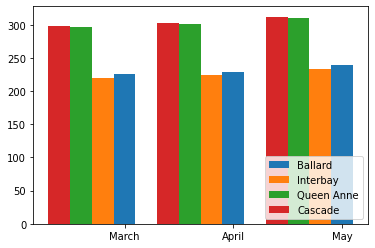

In [92]:
import matplotlib.pyplot as plt 

my_dates = [3, 4, 5]
my_neighbourhoods   = ["Ballard", "Interbay", "Queen Anne", "Cascade"]
results             = {nbh: [] for nbh in my_neighbourhoods}

for nbh in my_neighbourhoods:
    for date in my_dates:
        data = prepared_data(month=date, neighbourhood=nbh, accomodation_type='Boat')
        results[nbh].append(lm_model.predict(data)[0])


female = results['Ballard']
male = results['Interbay']

x_axis = np.arange(len(my_dates))

# Multi bar Chart
for index, key in enumerate(results.keys()):
    plt.bar(x_axis -0.2*index, results[key], width=0.2, label = key)

# Xticks

plt.xticks(x_axis, ['March', 'April', 'May'])

# Add legend

plt.legend(loc='lower right')

# Display

plt.show()


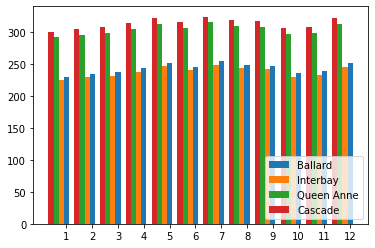

In [29]:
# how does it looks like all over the year?

import matplotlib.pyplot as plt 

my_dates = [i for i in range(1, 13, 1)]
my_neighbourhoods   = ["Ballard", "Interbay", "Queen Anne", "Cascade"]
results             = {nbh: [] for nbh in my_neighbourhoods}

for nbh in my_neighbourhoods:
    for date in my_dates:
        data = prepared_data(month=date, neighbourhood=nbh, accomodation_type='Boat')
        results[nbh].append(lm_model.predict(data)[0])


female = results['Ballard']
male = results['Interbay']

x_axis = np.arange(len(my_dates))

# Multi bar Chart
for index, key in enumerate(results.keys()):
    plt.bar(x_axis -0.2*index, results[key], width=0.2, label = key)

# Xticks

plt.xticks(x_axis, my_dates)

# Add legend

plt.legend(loc='lower right')

# Display

plt.show()

## Deployment
The result of this notebook is part of the blog post [Plan Your Seattle Accommodation the Data Scientific Way](blogpomst.md)